# We attempt to improve accuracy even further now, by using a more mathematical and highly intuitive feature engineering approach


In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
from matplotlib import pyplot as plt
import seaborn as sns

In [3]:
import numpy as np
import pandas as pd

In [4]:
from sklearn.preprocessing import ( StandardScaler,
                                    OneHotEncoder, OrdinalEncoder
                                    )

from sklearn.compose import ColumnTransformer

from sklearn.model_selection import GridSearchCV

from sklearn.pipeline import(   
                                Pipeline,
                                make_pipeline
                            )

from sklearn.neighbors import   KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier     

from sklearn.model_selection import (   train_test_split, 
                                        StratifiedKFold
                                    )



In [5]:
df= pd.concat([
    pd.read_csv('customer_churn_dataset-training-master.csv'),
    pd.read_csv('customer_churn_dataset-testing-master.csv')
],
    axis=0)

df.reset_index(drop= True, inplace= True)
df= df.dropna()

# Feature Engineering: Combining Subscription Type and Contract Length

## Motivation
Analysis revealed that **Subscription Type** alone had minimal correlation with churn rate, while **Contract Length** showed significant trends. Specifically, customers with **monthly contracts** exhibited the highest churn rates. To better represent the combined influence of these features on churn rate, we devised a systematic approach to integrate their effects into a single feature.

## Previous Approach
Initially, we concatenated the categorical values of **Subscription Type** and **Contract Length** to create nine distinct categories:
- `Bsc-Ann`, `Bsc-Mon`, `Bsc-Qua`
- `Prm-Ann`, `Prm-Mon`, `Prm-Qua`
- `Std-Ann`, `Std-Mon`, `Std-Qua`

However, this method lacked numerical intuition, limiting its usefulness for predictive modeling.

## Improved Approach
To better quantify the combined effect of **Subscription Type** and **Contract Length**, we introduced a scoring mechanism based on the relative impact of each feature on churn rate.

1. **Mapping Values**:
   - Assign numerical values (1-3) to each category in both features, prioritizing higher values for categories with greater churn impact.
   - For **Contract Length**:
     - Monthly = 3 (highest churn rate)
     - Annual  = 2
     - Quarterly= 1 (lowest churn rate)
   - For **Subscription Type**:
     - Basic = 3 (highest impact)
     - Standard = 2
     - Premium = 1 (lowest impact)

2. **Feature Combination Formula**:
   To emphasize the greater importance of **Contract Length** in churn prediction, we use the formula:
   $$
      \text{Subscription Contract} = \text{Subscription Type} + (\text{Contract Length} - 1)^2
   $$
   - Subtracting 1 from **Contract Length** ensures continuity and avoids unnecessary large values.
   - Squaring the **Contract Length** term highlights its stronger influence on churn rate.

3. **Resulting Range**:
   This approach generates a combined feature ranging from 1 to 7, reflecting the overall magnitude of churn influence from both features.

## Conclusion
The resulting feature is a numerically intuitive representation that encapsulates the combined effect of **Subscription Type** and **Contract Length**, tailored to reflect their individual and collective contributions to churn prediction.


In [6]:
subscription_map = {
    'Basic': 3,
    'Premium': 1,
    'Standard': 2
}

contract_map = {
    'Annual': 2,
    'Monthly': 3,
    'Quarterly': 1
}



In [7]:
df['Subscription Type'].value_counts()

Subscription Type
Standard    170630
Premium     170099
Basic       164477
Name: count, dtype: int64

In [8]:
df['Subscription Type']=df['Subscription Type'].map(subscription_map)

In [9]:
df['Subscription Type'].value_counts()

Subscription Type
2    170630
1    170099
3    164477
Name: count, dtype: int64

In [10]:
df['Contract Length'].value_counts()


Contract Length
Annual       198608
Quarterly    197364
Monthly      109234
Name: count, dtype: int64

In [11]:
df['Contract Length']=df['Contract Length'].map(contract_map)

In [12]:
df['Contract Length'].value_counts()

Contract Length
2    198608
1    197364
3    109234
Name: count, dtype: int64

In [13]:
df['Subscription_Contract'] = (df['Subscription Type']  + (df['Contract Length']-1)**2) 

In [14]:
df['Subscription_Contract'].value_counts()

Subscription_Contract
2    133998
3    130753
1     66718
4     64503
5     36478
7     36423
6     36333
Name: count, dtype: int64

In [15]:
df.groupby(['Subscription_Contract'], as_index= False)['Churn'].mean()

,Subscription_Contract,Churn
0,1,0.448290
1,2,0.453835
2,3,0.463936
3,4,0.474148
4,5,0.900214
5,6,0.902623
6,7,0.903056


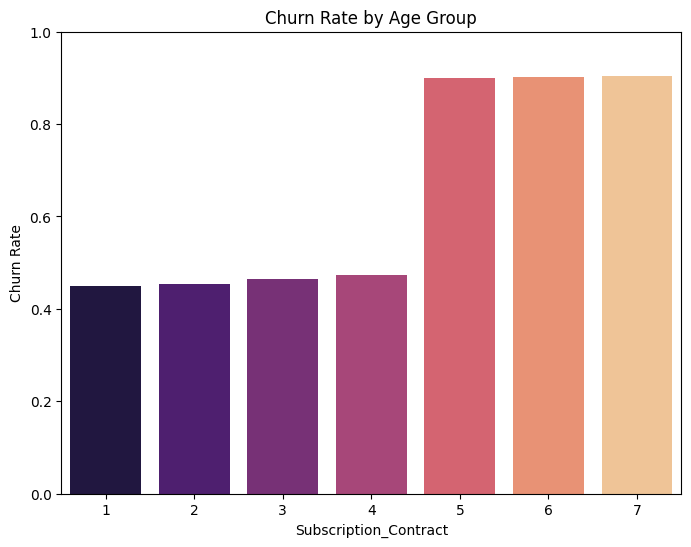

In [16]:
plt.figure(figsize=(8, 6))
sns.barplot(x='Subscription_Contract', y='Churn', data =df.groupby(['Subscription_Contract'], as_index= False)['Churn'].mean(), palette= 'magma')
plt.title('Churn Rate by Age Group')
plt.ylabel('Churn Rate')
plt.ylim(0, 1)
plt.show()

In [17]:
Irr_cols= ['CustomerID', 'Subscription Type', 'Contract Length']
df=df.drop(columns= Irr_cols, axis=1)

In [18]:
numerical_features = ['Age', 'Tenure', 'Usage Frequency', 'Support Calls', 'Payment Delay', 'Total Spend', 'Last Interaction', 'Subscription_Contract']
categorical_features_ohe = ['Gender']

num_pipeline= Pipeline(steps= [
    ('scale' , StandardScaler())
])

ohe_pipeline= Pipeline(steps= [
    ('one-hot', OneHotEncoder(handle_unknown='ignore', sparse_output= False))
])

column_transformer= ColumnTransformer(transformers= [
    ('numeric_pipeline', num_pipeline, numerical_features),
    ('one_hot_pipeline', ohe_pipeline, categorical_features_ohe)
    ],
    remainder= 'drop',
    n_jobs= -1
)

In [19]:
X = df.drop('Churn', axis=1)
y = df['Churn']

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,  random_state=42,  stratify=y) 

In [21]:
knn= KNeighborsClassifier(metric= 'euclidean', n_neighbors=9, weights='distance')

In [22]:
knn_pipe= make_pipeline(column_transformer, knn)

In [23]:
knn_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(n_jobs=-1,
                                   transformers=[('numeric_pipeline',
                                                  Pipeline(steps=[('scale',
                                                                   StandardScaler())]),
                                                  ['Age', 'Tenure',
                                                   'Usage Frequency',
                                                   'Support Calls',
                                                   'Payment Delay',
                                                   'Total Spend',
                                                   'Last Interaction',
                                                   'Subscription_Contract']),
                                                 ('one_hot_pipeline',
                                                  Pipeline(steps=[('one-hot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['Gender'])])),
                ('kneighborsclassifier',
                 KNeighborsClassifier(metric='euclidean', n_neighbors=9,
                                      weights='distance'))])

In [24]:
knn_pipe.score(X_test, y_test)

0.9048613447873162

In [25]:
gnb= GaussianNB(var_smoothing= 1e-11)

In [26]:
gnb_pipe= make_pipeline(column_transformer, gnb)

In [27]:
gnb_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(n_jobs=-1,
                                   transformers=[('numeric_pipeline',
                                                  Pipeline(steps=[('scale',
                                                                   StandardScaler())]),
                                                  ['Age', 'Tenure',
                                                   'Usage Frequency',
                                                   'Support Calls',
                                                   'Payment Delay',
                                                   'Total Spend',
                                                   'Last Interaction',
                                                   'Subscription_Contract']),
                                                 ('one_hot_pipeline',
                                                  Pipeline(steps=[('one-hot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['Gender'])])),
                ('gaussiannb', GaussianNB(var_smoothing=1e-11))])

In [28]:
gnb_pipe.score(X_train, y_train)

0.8691224354469967

In [29]:
gnb_pipe.score(X_test, y_test)

0.8702618713010432

## Mind blowing. By engineering just one feature, Subscription_Contract, by combining subscription_type, and contract_length with more mathematical intuition then before, we have so far increased our previously achieved accuracies for both of the above models

In [30]:
base_estimator = DecisionTreeClassifier(criterion='entropy', 
                                        max_depth=None, 
                                        min_samples_split=2, 
                                        min_samples_leaf=1)


adb = AdaBoostClassifier(base_estimator, 
                        n_estimators=50,    
                        learning_rate=1.0,  
                        random_state=42)

In [31]:
adb_pipe= make_pipeline(column_transformer, adb)

In [32]:
adb_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(n_jobs=-1,
                                   transformers=[('numeric_pipeline',
                                                  Pipeline(steps=[('scale',
                                                                   StandardScaler())]),
                                                  ['Age', 'Tenure',
                                                   'Usage Frequency',
                                                   'Support Calls',
                                                   'Payment Delay',
                                                   'Total Spend',
                                                   'Last Interaction',
                                                   'Subscription_Contract']),
                                                 ('one_hot_pipeline',
                                                  Pipeline(steps=[('one-hot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['Gender'])])),
                ('adaboostclassifier',
                 AdaBoostClassifier(estimator=DecisionTreeClassifier(criterion='entropy'),
                                    random_state=42))])

In [33]:
adb_pipe.score(X_test, y_test)

0.8859583143643237

In [34]:
rf= RandomForestClassifier(n_estimators=500, bootstrap= False, max_depth= None, min_samples_leaf=1, min_samples_split= 10)

In [35]:
rf_pipe= make_pipeline(column_transformer, rf)

In [36]:
rf_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(n_jobs=-1,
                                   transformers=[('numeric_pipeline',
                                                  Pipeline(steps=[('scale',
                                                                   StandardScaler())]),
                                                  ['Age', 'Tenure',
                                                   'Usage Frequency',
                                                   'Support Calls',
                                                   'Payment Delay',
                                                   'Total Spend',
                                                   'Last Interaction',
                                                   'Subscription_Contract']),
                                                 ('one_hot_pipeline',
                                                  Pipeline(steps=[('one-hot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['Gender'])])),
                ('randomforestclassifier',
                 RandomForestClassifier(bootstrap=False, min_samples_split=10,
                                        n_estimators=500))])

In [37]:
rf_pipe.score(X_test, y_test)

0.9366896933948259

In [38]:
y_pred= rf_pipe.predict(X_test)

In [39]:
prev_rf= pd.read_csv("random_forest_predictions.csv")

In [40]:
y_pred_old= prev_rf['y_pred']
y_true_prev= prev_rf['y_true']

In [41]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

In [42]:
accuracy_score(y_true_prev, y_pred_old)

0.9286237406227114

In [43]:
accuracy_score(y_test, y_pred)

0.9366896933948259

In [44]:
precision_score(y_true_prev, y_pred_old)

0.8979794526123838

In [45]:
precision_score(y_test, y_pred)

0.8982787358163985

In [46]:
recall_score(y_true_prev, y_pred_old)

0.9831369543129111

In [47]:
recall_score(y_test, y_pred)

0.9991087185154816